In [42]:
#-----------------------------------------------------#
#               Load in Libraries                     #
#-----------------------------------------------------#


#----------- NBA API Libraries -----------------------#
from nba_api.stats.static import players
from nba_api.stats.static import teams 
from nba_api.stats.endpoints import playergamelog
from nba_api.stats.library.parameters import SeasonAll

#----------- Data Libraries --------------------------#
import pandas as pd 
import numpy as np
import time
import os

#----------- Visualization Libraries -----------------#
import seaborn as sns
#import cufflinks as cf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
#import chart_studio.plotly as py
#import plotly.graph_objects as go
#import plotly.express as px
#%matplotlib inline

#from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
#init_notebook_mode(connected = True)
#cf.go_offline()

#---------- Define Vars for Plotting -----------------#
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)


In [3]:
#-----------------------------------------------------#
#               Load in Data                          #
#-----------------------------------------------------#

nba_1718 = pd.read_csv('./data/nba_2017_2018_per_game.csv')
nba_1819 = pd.read_csv('nba_2018_2019_per_game.csv')
nba_1920 = pd.read_csv('nba_2019_2020_per_game.csv')
nba_2021 = pd.read_csv('nba_2020_2021_per_game.csv')
nba_2122 = pd.read_csv('nba_2021_2022_per_game.csv')

### The Basketball Sharpe Ratio: Risk Adjusting Excess Points

If you've been following the NBA over the past few years, you'll be well aware of the scoring "inflation" that has taken place across the league. Gone are the days where being a 20+ points-per-game (PPG) scorer could get you an all-star nomination. Going back 10-years to the 2012-2013 NBA season, nine players averaged 20+ points-per-game. Go back five years to the 2017-2018 NBA season and you'll see 23 players averaged 20+ points-per-game. An in today's league for the 2022-2023 NBA season, a whoping 38 players are average 20+ points-per-game. In the past decade, the league has seen a 322% increase in 20+ point-per-game scorers. Sure, 20 is an arbitrary benchmark for someone who's considered a good scorer, but it goes to show the proliferation of points in today's league. 

While there are a host of factors that have given way to the scoring explosion over the past decade, free throws have always been a point of interest to me. Stephen Curry is one of the generation's elite scorers, and I've always admired his ability to create his own points off the dribble, meaning Steph can get buckets whenever he wants through his ability to get to the hoop, put up threes, or pop a mid-range jumper. In other words, Steph isn't realiant on the free-throw line or getting foul calls to get his points, or at least I'm of this belief. On the other hand, I can't help but think about Harden's MVP caliber years in Houston as being *heavily* reliant on getting foul calls on baited drivers and three-pointers. Harden generated historic scoring numbers during his MVP season, and to his credit he proved that he's one of the greatest to ever do it. But, his season stats prompted me to dig further into the source and value of his points. Basketball fans will know that despite Harden's massive offensive contribution, he dissapeared in the biggest moments and remains one of the 21st century MVPs without a NBA championship. Therefore, I'm left asking the question: **is there a better way to measure a player's offensive value besides pure PPG numbers?** 

Over the past semester I've gotten the chance study and work on problems in quantitative finance, leaving me with an interest to apply principles and concepts from this realm into other domains where applicable. One of the simplest but most influential contributions in this space is the Sharpe Ratio. The Sharpe Ratio, for those who aren't familiar with this concept, is an asset or portfolio performance metric created by William Sharpe back in 1996. This metric compares an investment's return with its risk, based on the belief that higher excess returns may come with greater volatility and risk over the same timeframe. When it comes to investing strategy, the Sharpe Ratio can be understood as a risk-adjusted performance metric to compare investing skill. 

$$ Sharpe = \frac{\mu_{i} - r_f}{\sigma_{i}} $$

The two components of the Sharpe Ratio that pique my interest in using it explain better offensive output in the NBA are (1) excess returns and (2) return volatility. Excess returns in finance are measured by the actual return on an assets minus the risk-free return. The risk-free return is simply the expected return on an asset with zero risk. While there's no truly risk-free asset, most investors treat this so called "risk-free rate" as the rate of return they expected at minimum from parking their money somewhere, most likely being the safest or lowest risk asset out there. This is often represented through the rate of return on short-term government bonds.

I liken this back to basketball by considering risk-free points as free-throw attempts. A free-throw is quite literally a chance at "free" points. We can solve one of the original problems I had with understanding a player's offensive value by distilling their points scored from those points that came through free-throws. Free-throw attempts and makes aren't the same idea, but if you're a player getting a lot of free-throw attempts you should be expected to produce more points since you're given more chances at "free" points. Most investors will adopt the same risk-free rate but not all basketball players have the same amount of free-throw attempts per game, but makes the concept of "excess points" something unique and specific to each player. 

The second concept from the Sharpe Ratio which I connect back to basketball is return volatility. This should be more straightforward, but it is just the measure of an asset's standard deviation over some timeframe. To put this in a basketball context, I treat this component of the Sharpe Ratio as the standard deviation of a player's points-per-game over an NBA season.

$$ B = \frac{\mu_{ppg} - \mu_{fta}}{\sigma_{ppg}} $$

Above I represent the translated Sharpe Ratio into basketball $(B)$ terms. The rest of this paper looks into the behaviour of this metric over the past handful of NBA seasons and trys to show a more accurate understanding of a player's offensive value compared to their raw PPG numbers. 

In [150]:
#-- Get Player Names Dictionary
player_dict = players.get_players()

#-- Define Function for Getting Season Games

def player_gl_api(player_name, season_year):
    
    nba_player = [player for player in player_dict if player['full_name'] == player_name][0]
    nba_player_id = nba_player['id']
    gamelog_nba_player = playergamelog.PlayerGameLog(player_id = nba_player_id, season = season_year)
    nba_player_gamelog_df = gamelog_nba_player.get_data_frames()[0]
    nba_player_gamelog_df['PLAYER'] = player_name

    return nba_player_gamelog_df

def get_bb_sharpe(player_name, season_year):
    
    nba_player = [player for player in player_dict if player['full_name'] == player_name][0]
    nba_player_id = nba_player['id']
    gamelog_nba_player = playergamelog.PlayerGameLog(player_id = nba_player_id, season = season_year)
    nba_player_gamelog_df = gamelog_nba_player.get_data_frames()[0]
    nba_player_gamelog_df['PLAYER'] = player_name
    nba_player_gamelog_df['PTS_PER_MIN'] = nba_player_gamelog_df['PTS'] / nba_player_gamelog_df['MIN']
    nba_player_gamelog_df['FTA_PER_MIN'] = nba_player_gamelog_df['FTA'] / nba_player_gamelog_df['MIN']


    games = len(nba_player_gamelog_df)
    fts = np.mean(nba_player_gamelog_df['FTM'] / nba_player_gamelog_df['PTS'])
    mu_ftper = np.mean(nba_player_gamelog_df['FTM'] / nba_player_gamelog_df['FTA'])
    mu_ppg = np.mean(nba_player_gamelog_df['PTS'])
    mu_fta = np.mean(nba_player_gamelog_df['FTA'])
    sigma_ppg = np.std(nba_player_gamelog_df['PTS'])
    ppg_fta_cov = np.cov(nba_player_gamelog_df['PTS'], nba_player_gamelog_df['FTA'])[1][0]
    ppg_fta_corr = np.corrcoef(nba_player_gamelog_df['PTS'], nba_player_gamelog_df['FTA'])[1][0]
    bb_sharpe_2 = (mu_ppg - mu_fta) / np.sqrt(ppg_fta_cov)
    sigma_min = np.std(nba_player_gamelog_df['MIN'])
    mu_ppgm = np.mean(nba_player_gamelog_df['PTS_PER_MIN'])
    mu_ftam = np.mean(nba_player_gamelog_df['FTA_PER_MIN'])
    sigma_ppgm = np.std(nba_player_gamelog_df['PTS_PER_MIN'])
    bb_sharpe_3 = np.mean(nba_player_gamelog_df['PTS_PER_MIN'] - nba_player_gamelog_df['FTA_PER_MIN']) / np.std(nba_player_gamelog_df['PTS_PER_MIN'])


    basketball_sharpe = (mu_ppg - mu_fta) / sigma_ppg

    temp_df = {'Player' : player_name, 'Season' : season_year, 'Games Played' : games
                , 'Average PPG' : mu_ppg, 'Volatility PPG' : sigma_ppg
                , 'Average FTA' : mu_fta, 'Average FTPER' : mu_ftper, 'Average FTS' : fts, 'nbaBB Sharpe' : basketball_sharpe
                , 'FTA PTS Correlation' : ppg_fta_corr, 'FTA PTS Covariance' : ppg_fta_cov, 'nbaBB Sharpe2' : bb_sharpe_2
                , 'Average PPGM' : mu_ppgm, 'Average FTAM' : mu_ftam, 'Volatility PPGM' : sigma_ppgm, 'Volatility MIN' : sigma_min, 'nbaBB Sharpe3' : bb_sharpe_3}

    temp_df = pd.DataFrame(temp_df, index = [0])

    return temp_df    

#-- Year Range BB Sharpe Function --#

def get_bb_sharpe_years(player_name, start_year, end_year):
    
    base = get_bb_sharpe(player_name, str(start_year))

    for year in range(start_year + 1, end_year + 1):
        base = pd.concat( [ base, get_bb_sharpe(player_name, str(year)) ], ignore_index = True)
    
    return base

#-- BB Sharpe function modified to pass in player IDs instead of player names --#

def get_bb_sharpe_id_pass(nba_player_id, nba_player_name, season_year):

    gamelog_nba_player = playergamelog.PlayerGameLog(player_id = nba_player_id, season = season_year)
    nba_player_gamelog_df = gamelog_nba_player.get_data_frames()[0]
    nba_player_gamelog_df['PLAYER'] = nba_player_name
    nba_player_gamelog_df['PTS_PER_MIN'] = nba_player_gamelog_df['PTS'] / nba_player_gamelog_df['MIN']
    nba_player_gamelog_df['FTA_PER_MIN'] = nba_player_gamelog_df['FTA'] / nba_player_gamelog_df['MIN']


    games = len(nba_player_gamelog_df)
    fts = np.mean(nba_player_gamelog_df['FTM'] / nba_player_gamelog_df['PTS'])
    mu_ftper = np.mean(nba_player_gamelog_df['FTM'] / nba_player_gamelog_df['FTA'])
    mu_ppg = np.mean(nba_player_gamelog_df['PTS'])
    mu_fta = np.mean(nba_player_gamelog_df['FTA'])
    sigma_ppg = np.std(nba_player_gamelog_df['PTS'])
    ppg_fta_cov = np.cov(nba_player_gamelog_df['PTS'], nba_player_gamelog_df['FTA'])[1][0]
    ppg_fta_corr = np.corrcoef(nba_player_gamelog_df['PTS'], nba_player_gamelog_df['FTA'])[1][0]
    bb_sharpe_2 = (mu_ppg - mu_fta) / np.sqrt(ppg_fta_cov)
    sigma_min = np.std(nba_player_gamelog_df['MIN'])
    mu_ppgm = np.mean(nba_player_gamelog_df['PTS_PER_MIN'])
    mu_ftam = np.mean(nba_player_gamelog_df['FTA_PER_MIN'])
    sigma_ppgm = np.std(nba_player_gamelog_df['PTS_PER_MIN'])
    bb_sharpe_3 = np.mean(nba_player_gamelog_df['PTS_PER_MIN'] - nba_player_gamelog_df['FTA_PER_MIN']) / np.std(nba_player_gamelog_df['PTS_PER_MIN'])


    basketball_sharpe = (mu_ppg - mu_fta) / sigma_ppg

    temp_df = {'Player' : nba_player_name, 'Season' : season_year, 'Games Played' : games
                , 'Average PPG' : mu_ppg, 'Volatility PPG' : sigma_ppg
                , 'Average FTA' : mu_fta, 'Average FTPER' : mu_ftper, 'Average FTS' : fts, 'nbaBB Sharpe' : basketball_sharpe
                , 'FTA PTS Correlation' : ppg_fta_corr, 'FTA PTS Covariance' : ppg_fta_cov, 'nbaBB Sharpe2' : bb_sharpe_2
                , 'Average PPGM' : mu_ppgm, 'Average FTAM' : mu_ftam, 'Volatility PPGM' : sigma_ppgm, 'Volatility MIN' : sigma_min, 'nbaBB Sharpe3' : bb_sharpe_3}

    temp_df = pd.DataFrame(temp_df, index = [0])

    return temp_df    

In [4]:
get_bb_sharpe('James Harden', '2022')

,Player,Season,Games Played,Average PPG,Volatility PPG,Average FTA,Average FTPER,Average FTS,nbaBB Sharpe,FTA PTS Correlation,FTA PTS Covariance,nbaBB Sharpe2,Average PPGM,Average FTAM,Volatility PPGM,Volatility MIN,nbaBB Sharpe3
0,James Harden,2022,36,21.0,6.459274,6.333333,0.84818,0.269832,2.270637,0.457505,8.2,5.121822,0.576141,0.173609,0.162296,4.336181,2.480228


In [8]:
#-----------------------------------------------------------#
#           Last Season BB-Sharpe Visualization             #
#-----------------------------------------------------------#

{
    "tags": [
        "hide-input",
    ]
}

#------------- Scrape Data ------------------#

top_25_2122 = nba_2122.sort_values(by = 'PTS', ascending = False).reset_index().iloc[0:26, 2]

last_season_df = pd.DataFrame()

for p in top_25_2122:
    
    try: 
        data = get_bb_sharpe(p, '2021')
        
        last_season_df = pd.concat([last_season_df, data], ignore_index = True)

        time.sleep(5)
    except:
        pass    

#------------- Build Visualization ------------------#

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x = np.round(last_season_df['nbaBB Sharpe'], 2), y = np.round(last_season_df['Average PPG'], 2)
        , marker=dict(
            size=16
            #, cmax=1
            #, cmin=0
            , color = last_season_df['Average FTPER']
            , colorbar=dict(
                title = "Avg. FT %"
            )
            , colorscale="Viridis"
        )
        , mode = "markers"
        , text = last_season_df['Player']
))

fig.update_traces(marker_line_width = 2, marker_size = 10)
fig.update_layout(title = 'Basketball Sharpe Ratios from the 2021-2022 NBA Season for a Sample of the Top Scorers'
                    , xaxis_title = 'Sharpe Ratios'
                    , yaxis_title = 'Average Points Per Game'
                    , autosize = True)

fig.show()

The scatterplot from above shows the relationship between BB-Sharpe Ratios and average points per game for players from the 2021-2022 NBA season. Joel Embiid won the league scoring title in a close race with LeBron, but if this analysis proves anything, it would suggest that LeBron is in a world of his own for true offensive value. LeBron has the highest BB-Sharpe Ratio out of all top scorers this season, and he averaged the second highest points per game. His BB-Sharpe Ratio is .24 higher than the next closest players who comparably average 4 and 6 fewer points a game, respectively. Moreover, the color-scale doesn't mean a ton for this plot, but it does show the free-throw percentage of players where LeBron is among the worst free-throw shooters captured in this sample. For what it's worth, he's leaving the few points on the table that he could be adding to his output as he's not as comporably efficient of a free-throw shooter.

While league scoring champion and MVP runner-up Joel Embiid might have average the most points-per-game last season, his BB-Sharpe Ratio is much lower compared to a handful of other top scorers. Embiid is known for getting a lot of his points from the free-throw line, and therefore he is expected to generate lower excess points compared to other players who play more on the perimeter and stay away from the "bruiser" style of basketball that big men tend towards. Nonetheless, if Embiid is going to generate lower excess points in comparison to other top scorers, his scoring volatility ($\sigma+{ppg}$) should also be lower since he's given more opportunities on a nightly basis to get "free" points. If this held true, then he would have a BB-Sharpe Ratio that's consistent with other top scorers. However, as evidenced by the lower BB-Sharpe Ratio, we can take away that Joel Embiid must also present greater volatility in his point-per-game output despite the greater share of opportunities for "free" points.

So what's the big deal with all this analysis? Analyze the offensive value of players at the top of the league might not be the most important thing. 

This analysis at the top of the league might be useful, but the true value in looking into a Sharpe Ratio for basketball might come from being able to differentiate the scoring / offensive output value from rotational players. It's no secret that LeBron is a top player, and regardless

In [5]:
HARDEN18 = player_gl_api('James Harden', '2017')
HARDEN18['GAME_DATE'] = pd.to_datetime(HARDEN18['GAME_DATE'])

In [78]:
HARDEN18.to_csv('HARDEN18.csv')

/var/folders/bh/f_n1lys118dd__48sbs22ffm0000gn/T/ipykernel_42613/82203813.py:60: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



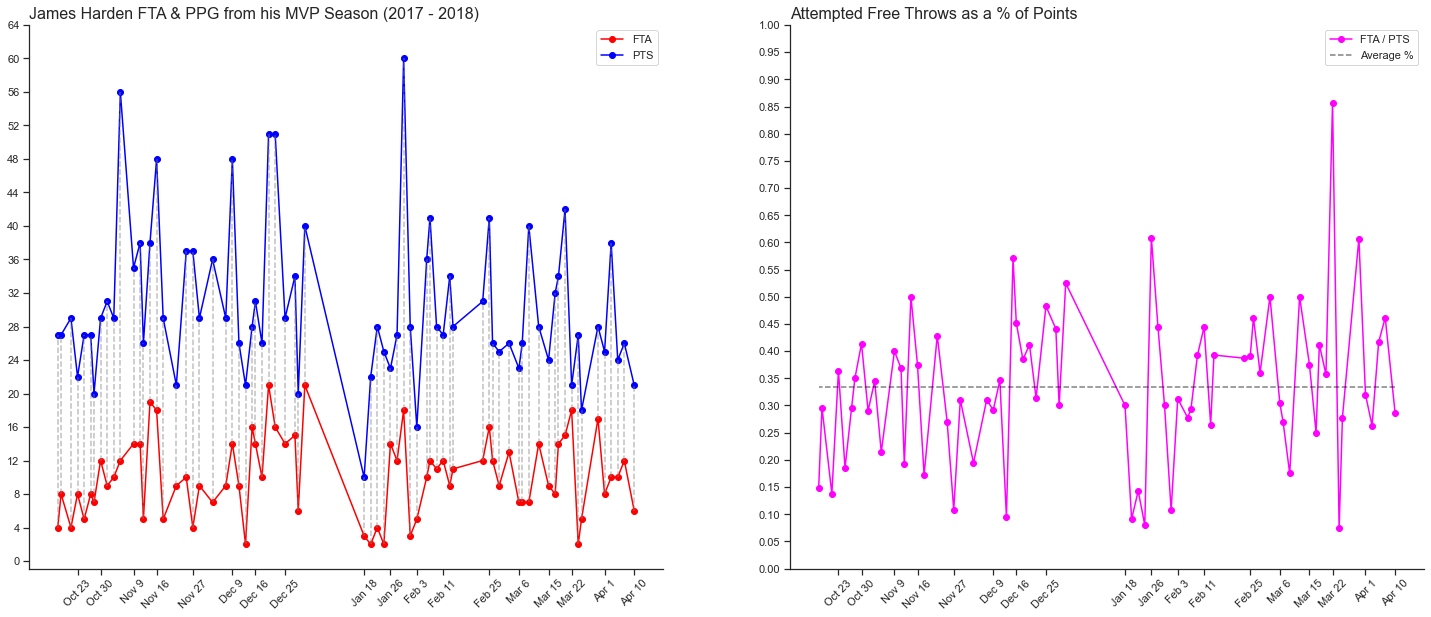

In [100]:
fig, ax = plt.subplots(1, 2, sharex = True, figsize = (25, 10))
fontparams = {'font' : 'Arial', 'fontsize' : 16}

#-------------------- James Harden PTS & FTA --------------------------------------#

#-- Plot
ax[0].plot(HARDEN18['GAME_DATE'], HARDEN18['FTA'], color = 'red', marker = 'o')
ax[0].plot(HARDEN18['GAME_DATE'], HARDEN18['PTS'], color = 'blue', marker = 'o')

for t in range(0, len(HARDEN18['GAME_DATE'])):
    ax[0].vlines(x = HARDEN18['GAME_DATE'][t]
                , ymin = HARDEN18['FTA'][t]
                , ymax = HARDEN18['PTS'][t]
                , color = 'gray', linestyles = 'dashed', alpha = .5)

#-- X Axis
x_ticks = []
for i in np.arange(0, len(HARDEN18['GAME_DATE']), step = 4):
    x_ticks.append(HARDEN18['GAME_DATE'][i])
x_ticks = pd.Series(x_ticks)

x_labs = []
for i in range(0, len(x_ticks)):
    x_labs.append(x_ticks[i].strftime('%b %-d'))
x_labs = pd.Series(x_labs)

ax[0].set_xticks(x_ticks)

ax[0].set_xticklabels(x_labs, rotation=45)

#-- Y Axis 
ax[0].set_yticks(np.arange(0, 68, step = 4))

#-- Title and Legend
ax[0].legend(['FTA', 'PTS'])
ax[0].set_title('James Harden FTA & PPG from his MVP Season (2017 - 2018)'
            , fontdict = fontparams
            , loc = 'left')


#-------------------- James Harden FTA / PTS --------------------------------------#
y_vector = (HARDEN18['FTA'] / HARDEN18['PTS'])
ax[1].plot(HARDEN18['GAME_DATE'], y_vector, color = 'magenta', linestyle = 'solid', marker = 'o')
ax[1].plot(HARDEN18['GAME_DATE'], np.repeat(np.mean(y_vector), len(y_vector)), color = 'black', linestyle = 'dashed', alpha = .5)



#-- X & Y Axis 
ax[1].set_xticklabels(x_labs, rotation=45)
ax[1].set_yticks(np.arange(0, 1.05, step = .05))

#-- Title and Legend
ax[1].set_title('Attempted Free Throws as a % of Points'
            , fontdict = fontparams
            , loc = 'left')

ax[1].legend(['FTA / PTS', 'Average %'])

fig.savefig('james_harden_dual_plot.png', dpi = 500)
fig.show()

The above two plots take a closer look into James Harden's scoring output during his MVP season. There is no doubt he put up an MVP worthy performance, with multiple 50+ point games in the era before the scoring explosion that we're currently experience. However, the closer examination does reveal that across the season, Harden's "risk-free" (free throw attempts) points accounted for 35% of his total points-per-game. This number doesn't mean too much on it's own, but it does allow us to understand that perhaps on any given night, 35% of James Harden's points could be coming from the free-throw line.

Another takeaway from the dual plot above would be the understanding in the relationship between massive scoring performances and total free throw attempts. An inital hypothesis I had when approaching this project was whether Harden's massive MVP-caliber scoring nights came from a disproportionate amount of free throw attempts. While I'm not testing for any statistical significance in evaluating this idea, the eye test suggests otherwise. It seems the big scoring nights from Harden aren't as heavily influenced by his trips to the free-throw line as some of his other nights. 

Finally, it would appear that Harden's reliance on the charity stripe to get points increases throughout the NBA season. The plot on the right is a time-series plot of the "share" of points that Harden scored that could've potentially come from the free-throw line (measured by total free throw attempts), and it suggests a slight positive trend from the start to the end of the season. The plot on the left showing his nightly free throw attempts may also provide better visual evidence as to the increase across the season. This finding is important insofar as perhaps Harden's MVP campaign is bolstered by his ability to foul-bait and receive calls as the season progressed. Or, maybe it gives into the idea that the better players get calls; as Harden built up a name for himself as the league's best scorer, he started to receive more favorable calls from the refs. Regardless, Harden's average free throw attempts per game clearly crept up along with his MVP odds. 

In [44]:
#--------- Plot the Sharpe Ratios of the Top Scorers in the 2017-2018 Season ------------#

top_30_1718 = nba_1718.iloc[0:31, 1].to_list()

TS_201718 = pd.DataFrame()

for p in top_30_1718:
    
    try: 
        data = get_bb_sharpe(p, '2017')
        
        TS_201718 = pd.concat([TS_201718, data], ignore_index = True)

        time.sleep(5)
        
    except:
        pass

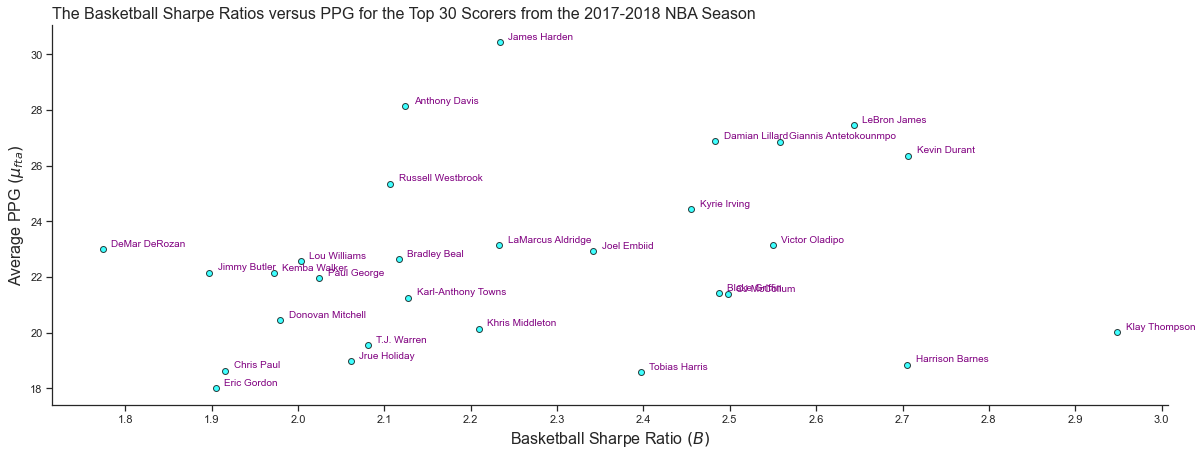

In [103]:
plt.figure(figsize = (20, 7))

plt.scatter(x = TS_201718['nbaBB Sharpe'], y = TS_201718['Average PPG'], ec = 'black', color = 'cyan', alpha = .75)

#-- Add player name labels 
xdodge = .01
ydodge = .1

for i in range(0, len(TS_201718)):
    plt.text(x = TS_201718['nbaBB Sharpe'][i] + xdodge, y = TS_201718['Average PPG'][i] + ydodge, s = TS_201718['Player'][i]
                , fontdict = dict(color = 'purple', size = 10)
                #, bbox = dict(facecolor= 'yellow', alpha = 0.5)
                )

#-- Adjust X & Y Axes 
plt.xticks(np.arange(1.8, 3.1, step = .1))
plt.yticks(np.arange(18, 32, step = 2))

plt.xlabel('Basketball Sharpe Ratio $(B)$'
            , fontdict = {'family' : 'arial', 'size' : 16})
plt.ylabel('Average PPG $(\mu_{fta})$'
            , fontdict = {'family' : 'arial', 'size' : 16})

plt.title('The Basketball Sharpe Ratios versus PPG for the Top 30 Scorers from the 2017-2018 NBA Season'
            , fontdict = {'family' : 'arial', 'size' : 16}
            , loc = 'left')

plt.savefig('B_Versus_PPG_1718.png', dpi = 300)

plt.show()

Plotted above on the x-axis is are the $B$ for the top 30 scorers (highest PPG) from the 2017-2018 NBA. The y-axis shows their points-per-game, conventional/easiest way to evaluate a player's scoring ability. Our MVP sits in his own layer of the chart, head and shoulders above any competition for points-per-game during his campaign. However, the if we look at this through the lens of players $B$ ratios, there's a different story. While Harden averaged the most PPG, there are 13 players with higher $B$ ratios despite scoring fewer points per game. Given that the components of the $B$ ratio are fairly simple, it is safe to say that all 13 of these players either take fewer free throw attempts per game or their nightly PPG remains consistent throughout the season. This logic is somewhat consistent with the efficient frontier in finance, where superior portfolios offer the best combination of high return with minimized risk.

One aspect of this $B$ ratio model that is fundamentally different from the Sharpe ratio in finance is the dynamic risk-free rate I am using in my analysis. If a portfolio manager is eveluating different portfolio choices, they are most likely going to be using the same risk-free rate to compute excess returns for all portfolios. However, in this model, the $B$ ratios are 100% player specific as each player has their own unique amount of average free throw attempts. Therefore, the risk-free rate in the model ($\mu_{fta}$) is dynamic as it adjusts with each player and produces a corresponding $B$. This is where the lines of basketball and finance do not neatly converge, but if I really wanted to keep it consistent I could use a league-wide average for free throw attempts while keeping the $\mu_{ppg}$ and $\sigma_{ppg}$ measures player specific. The dynamic risk-free rate is an integral part of the model and approach to the analysis, as taking out their respective free throw attempts from their points per game allows us to understand how many points **they are** responsible for versus points that the officiating or defense (unnecessary fouling) may be contributing. 

In [77]:
TS_201718.to_csv('TS_201718.csv')

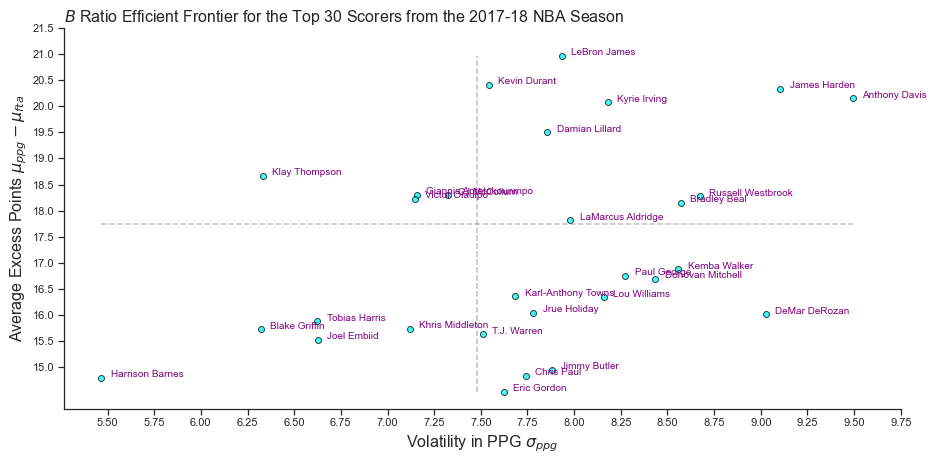

In [106]:
plt.figure(figsize = (15, 7))


#-- Base plot
y_vec = (TS_201718['Average PPG'] - TS_201718['Average FTA'])
x_vec = TS_201718['Volatility PPG']


plt.scatter(x = x_vec #-- BB Sharpe Numerator
            , y = y_vec #-- BB Sharpe Denominator
            , ec = 'black', color = 'cyan', alpha = .75)

#-- Add player name labels 
xdodge = .05
ydodge = .01

for i in range(0, len(TS_201718)):
    plt.text(x = x_vec[i] + xdodge, y = y_vec[i] + ydodge, s = TS_201718['Player'][i]
                , fontdict = dict(color = 'purple', size = 10)
                #, bbox = dict(facecolor= 'yellow', alpha = 0.5)
                )

#-- Add Quadrants 
def midpoint(vector):
    return (np.max(vector) + np.min(vector)) / 2

plt.vlines(x = midpoint(x_vec), ymin = np.min(y_vec), ymax = np.max(y_vec)
            , linestyles = 'dashed', color = 'grey', alpha = .5)

plt.hlines(y = midpoint(y_vec), xmin = np.min(x_vec), xmax = np.max(x_vec)
            , linestyles = 'dashed', color = 'grey', alpha = .5)

#-- Adjust X & Y Axes 
plt.yticks(np.arange(15, 22, step = .5))
plt.xticks(np.arange(5.5, 10, step = .25))

plt.ylabel('Average Excess Points $\mu_{ppg} - \mu_{fta}$'
            , fontdict = {'family' : 'arial', 'size' : 16})

plt.xlabel('Volatility in PPG $\sigma_{ppg}$'
            , fontdict = {'family' : 'arial', 'size' : 16})

plt.title('$B$ Ratio Efficient Frontier for the Top 30 Scorers from the 2017-18 NBA Season'
            , fontdict = {'family' : 'arial', 'size' : 16}
            , loc = 'left')

plt.savefig('sharpe_components_1718.png', dpi = 300)

plt.show()

The above plot decomponses the $B$ ratio and plots the excess returns on the y-axis while keeping volatility on the x-axis. This plot is designed to replicate an efficient frontier style plot, except we're looking at excess points per game and not the expected points per game. The difference is important as my goal is to take out "free" points that are measured by a player's free throw attempts. I also broke up the plot into 4 quadrants, assigned 1 through 4 moving clockwise from the top left. This makes quadrant 1 the top left corner, quadrant 2 the top right corner, quadrant 3 the bottom right corner, and quadrant 4 the bottom left corner. The best quadrant to be in is quadrant 1, as players in this quadrant exhibit higher excess points and lower volatility in their scoring. They can be considered the most consistent performers given their low volatility as well as some of the most efficient performers given their lack of reliance on free throws to get points. 

Quadrant 1 is home to only four players, and one on the border. CJ McCollum, Victor Oladipo, Giannis Antetokounmpo, and Klay Thompson are the four players from the 2017-2018 season who slide into this position. Kevin Durant is on the border. Our MVP, James Harden, finds himself in quadrant 2. Despite Harden's reliance on the free throw line to get his points, he is still such an offensive weapon that even when we take out his free throw attempts from nightly points per game, he remains amongst the league's best scorers. However, a big driver of his positioning in this chart is the scoring volatility. Referencing the first plot, it becomes clear that Harden has a lot of ups and downs to his scoring, with the nightly output somewhere in the range of 20 to 60 (more realistically 25 - 45) points. 

The chart shows that Harden has a scoring volatility $\sigma_{ppg}$ of ~9.25. He's only topped by Anthony Davis as the most volatile scorer during this season, which does have implications for a head coach or a GM. Some of the decisions or questions that come to mind when looking at the plot would be how much can I trust my superstar depending on what quadrant they land in? For a head coach, trying to run your offense through a player in quadrants 1 or 2 makes sense given that they are amongst the league's best scorers. But, at the same time, when a player has a PPG range of nearly 20 (one standard deviation above/below the mean), then a coach is at risk for an offensive collapse or meltdown if their superstar can't get it going. Obviously a team would not put all their eggs in one basket and most likely trust the offense from other players. Nonetheless, I see this as more of a consideration to make when offering someone a max contract, because will they really be *that guy* all season if their scoring is so volatile? 

When it comes to evaluating the talent out there during that 2017-2018 NBA season, this chart would suggest that LeBron James or Kevin Durant were "better" scorers when taking the quality of offense into account. Both LeBron and Durant are more consistent in their scoring with lower volatility, but still manage to put up the same amount of excess points (or more) than Harden. If one were to draw out an efficient frontier on this chart, both LeBron and Durant would end up as tangency points. They might not have dominated the media with flashy 60-point games, but they were consistent throughout the season-- perhaps a big reason why the two of them met in the NBA finals whereas Harden all but dissapeared during the Western Conference Finals. 

Finally, but maybe my favorite, takeaway from this season's $B$ ratio analysis would be understanding the greatness that is Klay Thompson. Figure 2, which plots players' $B$, shows that Klay has undoubtedly the highest $B$ out of all players that season. Klay's greatness does not come in the form of a player who a team would run their offense through, but instead comes through his consistency and control over his own output. Klay has the 3rd lowest scoring volatility out of the top 30 scorers from that season, but still remains in the top half of players in terms of excess points. What's even more interesting / insightful is the delta between his average and excess ppg. Klay only averages 1.34 free throw attempts per game compared to Harden who's averaging ~10. I'll concede that circumstances and roles are a big driver of the gap; a player who's always attacking and has the ball in his hands (Harden) is naturally going to get more calls than a three and D floor spacer (Klay). But, Klay is masterfully efficienct. He's able to put up nearly ~20 points per game with barely any reliance on the free-throw line. The next two closest scorers are Khris Middleton and T.J. Warren, both of which average 3.28 and 2.92 times more free throw attempts than Klay, respectively. 

In [115]:
nba_2122.sort_values(by = 'PTS', ascending = False).iloc[0:31, 1]

206                Joel Embiid
368               LeBron James
15       Giannis Antetokounmpo
198               Kevin Durant
808                 Trae Young
178                Luka Dončić
167              DeMar DeRozan
356               Kyrie Irving
526                  Ja Morant
391               Nikola Jokić
708               Jayson Tatum
70                Devin Booker
515           Donovan Mitchell
159              Stephen Curry
736         Karl-Anthony Towns
254    Shai Gilgeous-Alexander
442                Zach LaVine
251                Paul George
492                CJ McCollum
452             Damian Lillard
93                Jaylen Brown
230               De'Aaron Fox
160              Anthony Davis
48                Bradley Beal
667              Pascal Siakam
355             Brandon Ingram
283               James Harden
490                CJ McCollum
603         Kristaps Porziņģis
282               James Harden
246             Darius Garland
Name: Player, dtype: object

In [116]:
#---------- 2021 - 2022 Applications -------------# 

top_30_2122 = nba_2122.sort_values(by = 'PTS', ascending = False).iloc[0:31, 1].to_list()

TS_202122 = pd.DataFrame()

for p in top_30_2122:
    
    try: 
        data = get_bb_sharpe(p, '2021')
        
        TS_202122 = pd.concat([TS_202122, data], ignore_index = True)

        time.sleep(5)
        
    except:
        pass

In [128]:
TS_202122 = pd.DataFrame()

for p in top_30_2122:
    
    try: 
        data = get_bb_sharpe(p, '2021')
        
        TS_202122 = pd.concat([TS_202122, data], ignore_index = True)

        time.sleep(5)
        
    except:
        pass

In [129]:
TS_202122

,Player,Season,Games Played,Average PPG,Volatility PPG,Average FTA,Average FTPER,Average FTS,nbaBB Sharpe,FTA PTS Correlation,FTA PTS Covariance,nbaBB Sharpe2,Average PPGM,Average FTAM,Volatility PPGM,Volatility MIN,nbaBB Sharpe3
0,Joel Embiid,2021,68,30.573529,8.354844,11.808824,0.812105,0.324661,2.245967,0.489108,18.290386,4.387633,0.906842,0.350611,0.241025,3.698639,2.307775
1,LeBron James,2021,56,30.267857,7.872854,6.000000,0.765082,0.151436,3.082473,0.361383,8.945455,8.113911,0.816880,0.159997,0.218168,4.208796,3.010909
2,Giannis Antetokounmpo,2021,67,29.880597,7.876893,11.432836,0.727784,0.280846,2.342010,0.487564,16.113071,4.595730,0.908190,0.349615,0.215474,4.138933,2.592307
3,Kevin Durant,2021,55,29.872727,8.423030,7.436364,0.904652,0.230979,2.663693,0.467082,13.426936,6.122996,0.807333,0.202276,0.195832,5.476199,3.089668
4,Trae Young,2021,76,28.355263,8.990791,7.276316,0.897823,0.237153,2.344504,0.474964,16.620526,5.170428,0.817337,0.206640,0.255171,3.284944,2.393285
5,Luka Doncic,2021,65,28.415385,7.970894,7.523077,0.730670,0.202451,2.621075,0.391968,11.091827,6.273138,0.803649,0.212596,0.209965,3.670255,2.814999
6,DeMar DeRozan,2021,76,27.868421,7.778753,7.802632,0.859084,0.246081,2.579564,0.523176,15.387018,5.115393,0.767493,0.213856,0.186147,3.392492,2.974195
7,Kyrie Irving,2021,29,27.448276,11.177521,4.448276,0.911355,0.135287,2.057701,0.743532,33.649015,3.964986,0.725285,0.116745,0.290168,4.551724,2.097200
8,Ja Morant,2021,57,27.438596,9.427503,7.280702,0.772504,0.222277,2.138201,0.424218,17.249687,4.853495,0.812950,0.216007,0.239471,5.224831,2.492759
9,Jayson Tatum,2021,76,26.921053,8.667488,6.171053,0.836058,0.205882,2.394004,0.260601,6.840351,7.933757,0.752629,0.170431,0.238839,4.176673,2.437618


In [126]:
top_30_2122[5] = 'Luka Doncic'
top_30_2122[9] = 'Nikola Jokic' #-- player ID 203999
top_30_2122[28] = 'Kristaps Porzingis'

In [135]:
TS_202122.to_csv('TS_202122.csv')

In [127]:
print(top_30_2122)

['Joel Embiid', 'LeBron James', 'Giannis Antetokounmpo', 'Kevin Durant', 'Trae Young', 'Luka Doncic', 'DeMar DeRozan', 'Kyrie Irving', 'Ja Morant', 'Nikola Jokic', 'Jayson Tatum', 'Devin Booker', 'Donovan Mitchell', 'Stephen Curry', 'Karl-Anthony Towns', 'Shai Gilgeous-Alexander', 'Zach LaVine', 'Paul George', 'CJ McCollum', 'Damian Lillard', 'Jaylen Brown', "De'Aaron Fox", 'Anthony Davis', 'Bradley Beal', 'Pascal Siakam', 'Brandon Ingram', 'James Harden', 'CJ McCollum', 'Kristaps Porzingis', 'James Harden', 'Darius Garland']


/var/folders/bh/f_n1lys118dd__48sbs22ffm0000gn/T/ipykernel_42613/2729408561.py:85: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



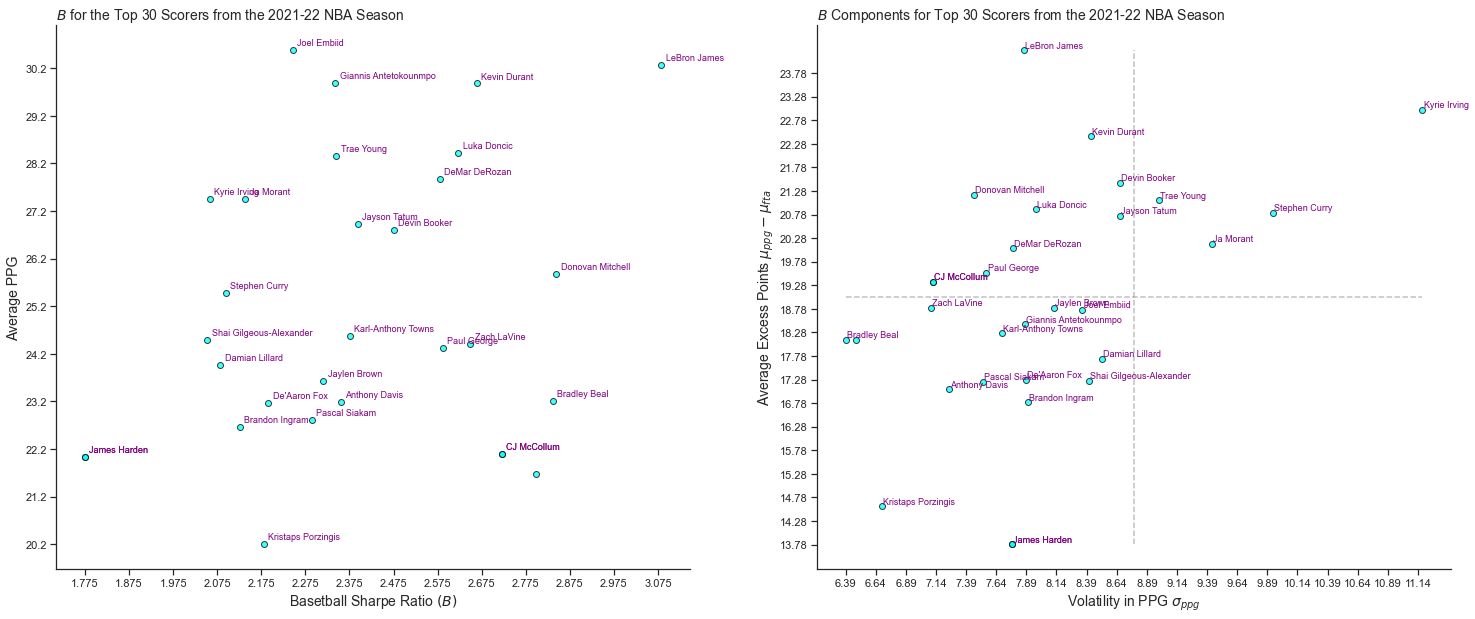

In [134]:
#------ Top 30 Scorers Plot ---------#
fig, ax = plt.subplots(1, 2, sharex = False, figsize = (25, 10))
fontparams = {'font' : 'Arial', 'fontsize' : 14}

#------ Sharpe Ratios Plot --------#
x_vec_1 = TS_202122['nbaBB Sharpe']
y_vec_1 = TS_202122['Average PPG']
s_vec_1 = TS_202122['Player']

ax[0].scatter(x = x_vec_1
                , y = y_vec_1
                , ec = 'black', color = 'cyan', alpha = .75)

#-- Add player name labels 
xdodge = .01
ydodge = .1

for i in range(0, len(TS_201718)):
            ax[0].text(x = x_vec_1[i] + xdodge
                        , y = y_vec_1[i] + ydodge
                        , s = s_vec_1[i]
                , fontdict = dict(color = 'purple', size = 9)
                #, bbox = dict(facecolor= 'yellow', alpha = 0.5)
                )


#-- Adjust X & Y Axes 
ax[0].set_xticks(np.arange(np.min(x_vec_1), np.max(x_vec_1), step = .1))
ax[0].set_yticks(np.arange(np.min(y_vec_1), np.max(y_vec_1), step = 1))

ax[0].set_xlabel('Basetball Sharpe Ratio $(B)$'
            , fontdict = fontparams)
ax[0].set_ylabel('Average PPG'
            , fontdict = fontparams)

ax[0].set_title('$B$ for the Top 30 Scorers from the 2021-22 NBA Season'
            , fontdict = fontparams
            , loc = 'left')

#------ Components Plot ----------#
y_vec = (TS_202122['Average PPG'] - TS_202122['Average FTA'])
x_vec = TS_202122['Volatility PPG']
s_vec = TS_202122['Player']


ax[1].scatter(x = x_vec #-- BB Sharpe Numerator
            , y = y_vec #-- BB Sharpe Denominator
            , ec = 'black', color = 'cyan', alpha = .75)

#-- Add player name labels 
ydodge = .05
xdodge = .01

for i in range(0, len(TS_201718)):
    ax[1].text(x = x_vec[i] + xdodge, y = y_vec[i] + ydodge, s = s_vec[i]
                , fontdict = dict(color = 'purple', size = 9)
                #, bbox = dict(facecolor= 'yellow', alpha = 0.5)
                )

#-- Add Quadrants 
def midpoint(vector):
    return (np.max(vector) + np.min(vector)) / 2

ax[1].vlines(x = midpoint(x_vec), ymin = np.min(y_vec), ymax = np.max(y_vec)
            , linestyles = 'dashed', color = 'grey', alpha = .5)

ax[1].hlines(y = midpoint(y_vec), xmin = np.min(x_vec), xmax = np.max(x_vec)
            , linestyles = 'dashed', color = 'grey', alpha = .5)

#-- Adjust X & Y Axes 
ax[1].set_yticks(np.arange(np.round(np.min(y_vec),2), np.round(np.max(y_vec),2), step = .5))
ax[1].set_xticks(np.arange(np.round(np.min(x_vec),2), np.round(np.max(x_vec),2), step = .25))

ax[1].set_ylabel('Average Excess Points $\mu_{ppg} - \mu_{fta}$'
            , fontdict = fontparams)
ax[1].set_xlabel('Volatility in PPG $\sigma_{ppg}$'
            , fontdict = fontparams)

ax[1].set_title('$B$ Components for Top 30 Scorers from the 2021-22 NBA Season'
            , fontdict = fontparams
            , loc = 'left')

fig.savefig('joint_sharpe_plots_for_2122.png', dpi = 500)

fig.show()

The above plot takes a look at the application of the $B$ ratio to the last complete NBA season from 2021 - 2022. 

In [155]:
data

,Player,Season,Games Played,Average PPG,Volatility PPG,Average FTA,Average FTPER,Average FTS,nbaBB Sharpe,FTA PTS Correlation,FTA PTS Covariance,nbaBB Sharpe2,Average PPGM,Average FTAM,Volatility PPGM,Volatility MIN,nbaBB Sharpe3
0,Darius Garland,2022,47,22.042553,8.44244,4.957447,0.854154,0.195314,2.023717,0.661578,19.306198,3.888385,0.617241,0.13616,0.199453,5.373509,2.411998


### 2022 - 2023 Season Applications

In [151]:
#-- Getting data from the 2022-2023 NBA Season --#

#- Fetch data from NBA API for league leaders
from nba_api.stats import endpoints
data = endpoints.leagueleaders.LeagueLeaders()
data = data.get_data_frames()[0]
data.sort_values(by = 'PTS', ascending = False)

#-- Create PPG variable and sort on that index
data['PPG'] = data['PTS'] / data['GP']
data =  data.sort_values(by = 'PPG', ascending = False)
data = data.reset_index()
data.iloc[1:31,:]

#-- Create two lists of IDs and names for passing into Sharpe function
nba_2k23_player_ids = data.iloc[1:31,1].to_list()
nba_2k23_player_names = data.iloc[1:31,3].to_list()



In [165]:
#-- Get Sharpe data for 2022-2023 season --#

#-- Initiate empty data frame
TS_2K23 = pd.DataFrame()

#-- Loop through lists from above cell to pull in Sharpe data
for i in range(0, len(nba_2k23_player_ids)):
    
    try:
        #-- Sharpe function 
        function_df = get_bb_sharpe_id_pass(nba_2k23_player_ids[i], nba_2k23_player_names[i], '2022') 
        
        TS_2K23 = pd.concat([TS_2K23, function_df], ignore_index = True) 

        #-- Rest loop to prevent web API overload    
        time.sleep(2)
        
    except:
        pass

/var/folders/bh/f_n1lys118dd__48sbs22ffm0000gn/T/ipykernel_42613/3423341340.py:92: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



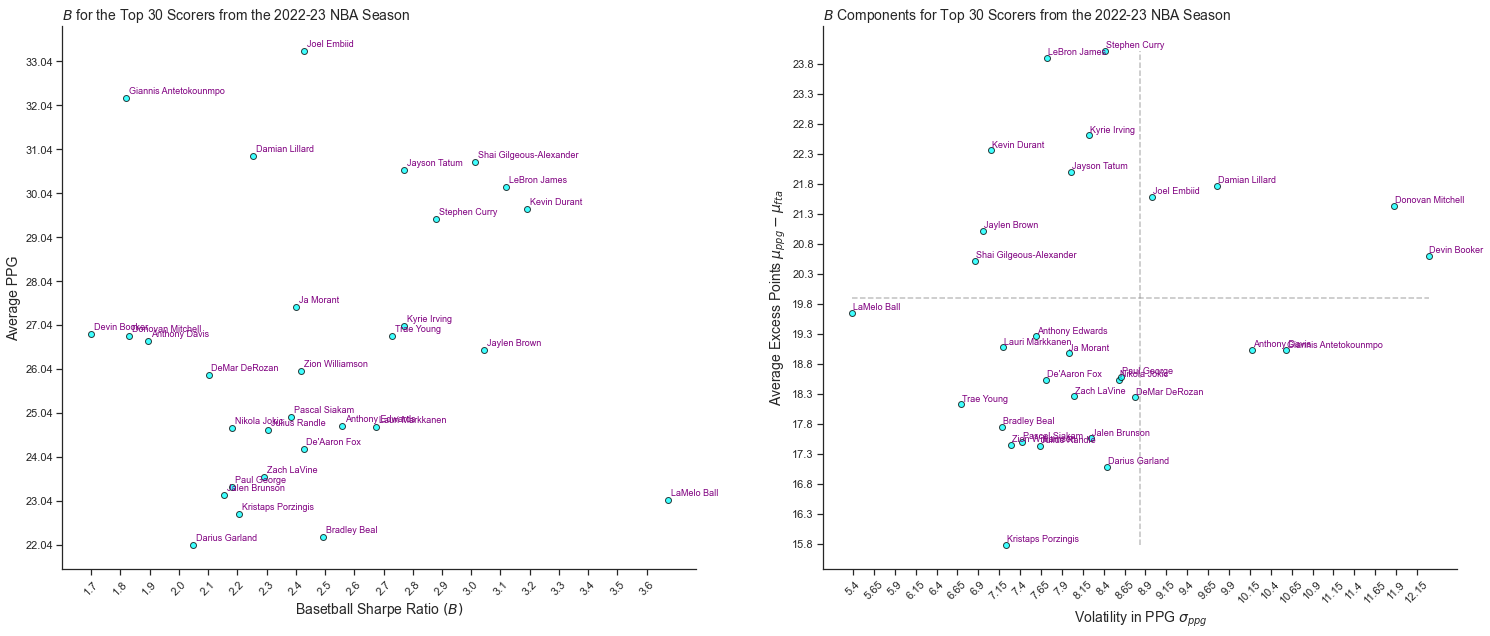

In [173]:
#-- Joint Plot for B Ratio and Efficient Frontier Visualization --#

#-- Initate plot figure
fig, ax = plt.subplots(1, 2, sharex = False, figsize = (25, 10))
fontparams = {'font' : 'Arial', 'fontsize' : 14}

#-- The first subplot will be the BB Sharpe Ratio vs PPG Plot
x_vec_1 = TS_2K23['nbaBB Sharpe']
y_vec_1 = TS_2K23['Average PPG']
s_vec_1 = TS_2K23['Player']

ax[0].scatter(x = x_vec_1
                , y = y_vec_1
                , ec = 'black', color = 'cyan', alpha = .75)

#-- Add player name labels 
xdodge = .01
ydodge = .1

for i in range(0, len(TS_2K23)):
            ax[0].text(x = x_vec_1[i] + xdodge
                        , y = y_vec_1[i] + ydodge
                        , s = s_vec_1[i]
                , fontdict = dict(color = 'purple', size = 9)
                #, bbox = dict(facecolor= 'yellow', alpha = 0.5)
                )


#-- Adjust X & Y Axes 
ax[0].set_xticks(np.arange(np.min(x_vec_1), np.max(x_vec_1), step = .1))
ax[0].set_yticks(np.arange(np.min(y_vec_1), np.max(y_vec_1), step = 1))
ax[0].set_xticklabels(np.round(np.arange(np.min(x_vec_1), np.max(x_vec_1), step = 0.1),1), rotation = 45)
# ax[0].set_yticklabels(np.arange(np.min(y_vec_1), np.max(y_vec_1), step = 1))


ax[0].set_xlabel('Basetball Sharpe Ratio $(B)$'
            , fontdict = fontparams)
ax[0].set_ylabel('Average PPG'
            , fontdict = fontparams)

ax[0].set_title('$B$ for the Top 30 Scorers from the 2022-23 NBA Season'
            , fontdict = fontparams
            , loc = 'left')

#-- B ratio components plot
y_vec = (TS_2K23['Average PPG'] - TS_2K23['Average FTA'])
x_vec = TS_2K23['Volatility PPG']
s_vec = TS_2K23['Player']


ax[1].scatter(x = x_vec #-- BB Sharpe Denominator
            , y = y_vec #-- BB Sharpe Numerator 
            , ec = 'black', color = 'cyan', alpha = .75)

#-- Add player name labels 
ydodge = .05
xdodge = .01

for i in range(0, len(TS_2K23)):
    ax[1].text(x = x_vec[i] + xdodge, y = y_vec[i] + ydodge, s = s_vec[i]
                , fontdict = dict(color = 'purple', size = 9)
                #, bbox = dict(facecolor= 'yellow', alpha = 0.5)
                )

#-- Add Quadrants 
def midpoint(vector):
    return (np.max(vector) + np.min(vector)) / 2

ax[1].vlines(x = midpoint(x_vec), ymin = np.min(y_vec), ymax = np.max(y_vec)
            , linestyles = 'dashed', color = 'grey', alpha = .5)

ax[1].hlines(y = midpoint(y_vec), xmin = np.min(x_vec), xmax = np.max(x_vec)
            , linestyles = 'dashed', color = 'grey', alpha = .5)

#-- Adjust X & Y Axes 
ax[1].set_yticks(np.arange(np.round(np.min(y_vec),1), np.round(np.max(y_vec),1), step = .5))
ax[1].set_yticklabels(np.arange(np.round(np.min(y_vec),1), np.round(np.max(y_vec),1), step = .5))
ax[1].set_xticks(np.arange(np.round(np.min(x_vec),1), np.round(np.max(x_vec),1), step = .25))
ax[1].set_xticklabels(np.arange(np.round(np.min(x_vec),1), np.round(np.max(x_vec),1), step = .25), rotation = 45)

ax[1].set_ylabel('Average Excess Points $\mu_{ppg} - \mu_{fta}$'
            , fontdict = fontparams)
ax[1].set_xlabel('Volatility in PPG $\sigma_{ppg}$'
            , fontdict = fontparams)

ax[1].set_title('$B$ Components for Top 30 Scorers from the 2022-23 NBA Season'
            , fontdict = fontparams
            , loc = 'left')

fig.savefig('joint_sharpe_plots_for_2K23.png', dpi = 500)

fig.show()

The above plot applies the $B$ ratio to the 2022-2023 NBA season and decomposes the components for the top 30 players in terms of their average PPG. Not all players have played the same amount of games which does have an unfair impact on the volatility for those who have played more games, but for the most part all players in this sample have played sufficient games to get a reliable estimate. 

The first observation from these two plots side by side is the scaling of the y-axis from the first plot to the next. The left plot measures PPG on the y-axis whereas the y-axis on the right plot measures the excess PPG, taking out free throw attempts from a players PPG. There's nearly a 10-point difference between the two y-axes, suggesting that free throws have become an even larger part of scoring today. There's some great movement between positioning on the two graphs as well. For example, Joel Embiid is averaging the most PPG in the league as of today, but when we take out free throw attempts from this number he falls back to 6th. Embiid is averaging ~33 points per game but subtracting free throw attempts leaves him with ~21.5. Yes, Embiid isn't making all 12 of his free throw attempts every single night, but taking the free throw attempts out of his PPG numbers shows us how many points he's individually generating every single night versus points that come from calls. 

The quadrant 1 players this season are Stephen Curry, LeBron James, Kevin Durant, Kyrie Irving, Jason Tatum, Jaylen Brown, and Shai Gilgeous-Alexander (SGA). SGA making the first quadrant is a bit of a surprise to me, but I'll admit I haven't watched a ton of OKC basketball this season. He's been on a scoring rampage this season, putting up nearly ~30 PPG and the low volatility (relative to the rest of the league) suggests he's able to keep up the output. Granted, there's roughly a 10-point difference between his PPG averages and excess point numbers but this is in line with the drop for most other players too. LeBron and Steph standout amongst the rest, masterfully efficient scorers who you can depend on. LeBron continues to impress on the court, but it sometimes feels like his performances are drowned out by the impressive feats from other rising stars across the league. If anything, this chart should re-affirm his greatness as he's able to consistently to put up these incredible scoring numbers on his own, ahead of the rest of the league. 

Two players who I'm surprised seem to perform poorly under this $B$ ratio evaluation are Nikola Jokic and Giannis Antetokounmpo. Jokic and the Nuggests are at the top of the Western conference and he's been building a case for his 3rd consecutive MVP. Giannis and the Bucks have been dominant too, winners of nine in a row of late. Jokic place into quadrant 4 in the components plot, and has a $B$ ratio of 2.2. Giannis is in quadrant 3 with a Sharpe ratio of 1.8. Jokic doesn't do anything poorly but he also doesn't stand out amongst the rest, pushing the argument that his contributions to his team's success and MVP campaign come from non-scoring outputs. Giannis on the other hand is one of the most volatile scorers and has a massive drop off in his excess points. He averages nearly 32 PPG but only puts up 18 PPG net of free throw attempts. Giannis has always been a free throw magnent, so this delta isn't too surprising. But, the scoring volatility might be somewhat of a concern for a limited offense. Without Khris Middleton, Milwuakee runs their offense heavily through Giannis and if his scoring volatility is high, I'd be concerned about their ability to hold up in a playoff series against another Eastern conference title contender like Boston. 

### Conclusion: Where do we go from here? 
---

This application of the Sharpe ratio to basketball is by no means perfect. The idea came to me while going over some of the concepts I had learned about over my fall semester. To start, perhaps a dynamic risk-free rate, which is the backbone of a lot of my analysis, is not the best way to adjust a player's scoring and something more consistent should be used. This gets into a larger conversation about how should we treat free throws as part of the game and if free throw attempts or free throw makes should be the "risk-free" measure of points. I settled on using attempts originally, since if you're given a free throw the expectation is that you should make it. However, maybe free throws are not truly risk-free points. Using attempts was my way to take out a source of points that high free throw percentage shooters could use to farm points knowing they were going to get the foul call and a trip to the free throw line. But, for some players like poor shooting big men, free throw attempts are a huge part of their game as a result of opposing defenders fouling them during physical battling below the hoop. Their attempts may be less a product of the referee making calls in their favor and more a product of a defense choosing to foul over giving them the easy bucket. 

Going forward, I plan to revisit the components of teh $B$ ratio in the first place. I've already discussed some of my concerns with using pure free throw attempts as the excess adjustment, but there are more variables that I think might have better use in a basketball context. The direct application of a finance metric to basketball doesn't perfectly capture aspects of gameplay that I'm looking for, and thus a need to include or modify terms is created. A few parameters that might make sense to include would be the correlation or covariance between a players PPG and their FTA as a measure of their "risk-free" dependency. Moreover, not all players are getting the same amount of playing opportunities, measured by minutes played. Minute adjusting all stats could yield different insights and produce more equitable results. 

The next iteration of this analysis will have a focus on identifying hidden talent. The analysis done in this paper covers MVPs and the top 30 scorers in a given NBA season. Any insights or gains produced from my work are at the margins; the players under my focus are **all** incredible and therefore regardless of how high their $B$ ratio is, any team would be lucky to have them on their roster. But, deviations in the $B$ ratio have more signficant implications when we move towards the middle of the pack, looking at role players or rotational pieces in roster construction. Applying the $B$ ratio to understand who to go after in free agency and who to stay away from can make a bigger difference in pushing a team towards a title compared to when the analysis is applied at the top of the league. 

One final consideration, tying back the analysis to a financial concept, would be to apply the use of the individual $B$ ratio to a 5-player rotation metric and optimize for the highest $B$. In other words, could a GM or coach treat a 5-player lineup like a 5-asset portfolio? The capital would need weight allocations to each of the five players, much like in a portfolio one allocates their capital across assets to either minimize risk or maximize return under some risk tolerance. One could treat returns like points and risk the standard deviation of a players points. Optimization would focus on maximizing total points from the lineup, with the decisions being how much would you invest in each of your positions subject to salary cap constraints. This is a rough idea, but a thought motivated by the efficient frontier plots. 

This concludes my introduction of the basketball Sharpe ratio $(B)$. Comments and feedback are always appreciated. Thank you for taking the time to read my work, and as always, go Cavs! 

/var/folders/bh/f_n1lys118dd__48sbs22ffm0000gn/T/ipykernel_42613/3801504392.py:76: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



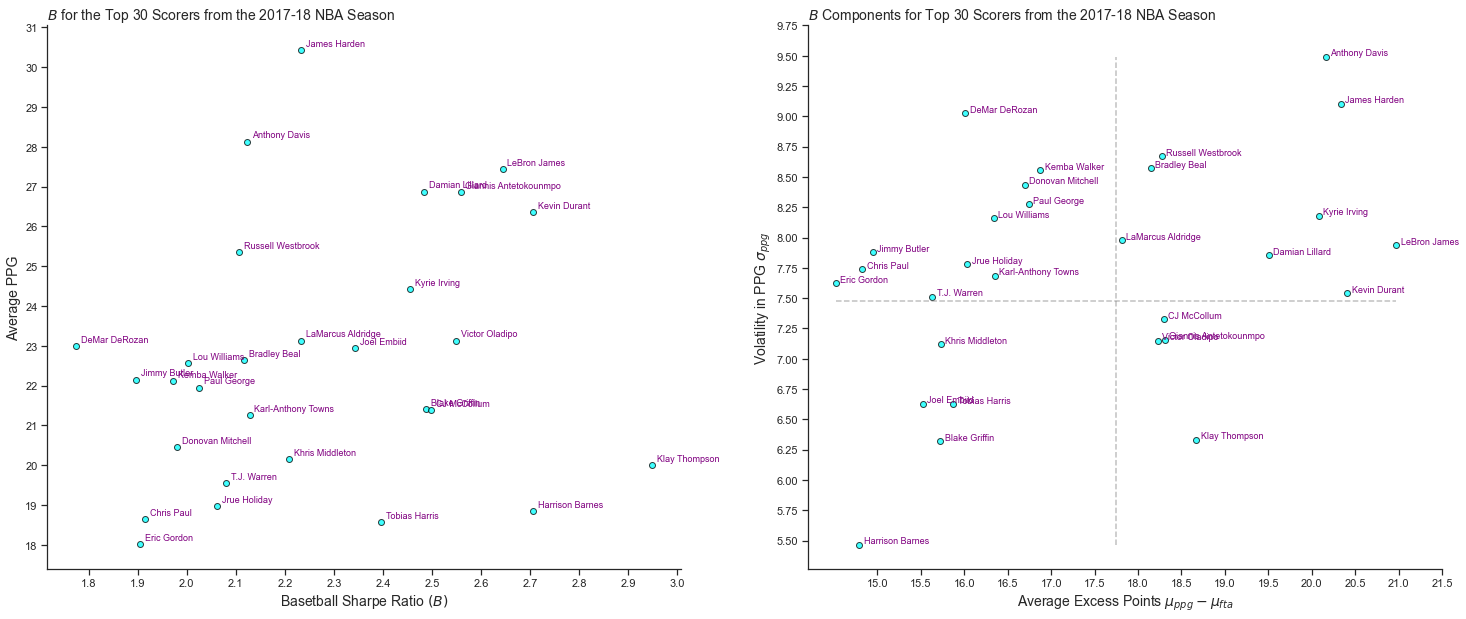

In [101]:
#------ Top 30 Scorers Plot ---------#
fig, ax = plt.subplots(1, 2, sharex = False, figsize = (25, 10))
fontparams = {'font' : 'Arial', 'fontsize' : 14}

#------ Sharpe Ratios Plot --------#
ax[0].scatter(x = TS_201718['nbaBB Sharpe'], y = TS_201718['Average PPG'], ec = 'black', color = 'cyan', alpha = .75)

#-- Add player name labels 
xdodge = .01
ydodge = .1

for i in range(0, len(TS_201718)):
            ax[0].text(x = TS_201718['nbaBB Sharpe'][i] + xdodge, y = TS_201718['Average PPG'][i] + ydodge, s = TS_201718['Player'][i]
                , fontdict = dict(color = 'purple', size = 9)
                #, bbox = dict(facecolor= 'yellow', alpha = 0.5)
                )


#-- Adjust X & Y Axes 
ax[0].set_xticks(np.arange(1.8, 3.1, step = .1))
ax[0].set_yticks(np.arange(18, 32, step = 1))

ax[0].set_xlabel('Basetball Sharpe Ratio $(B)$'
            , fontdict = fontparams)
ax[0].set_ylabel('Average PPG'
            , fontdict = fontparams)

ax[0].set_title('$B$ for the Top 30 Scorers from the 2017-18 NBA Season'
            , fontdict = fontparams
            , loc = 'left')

#------ Components Plot ----------#
x_vec = (TS_201718['Average PPG'] - TS_201718['Average FTA'])
y_vec = TS_201718['Volatility PPG']


ax[1].scatter(x = x_vec #-- BB Sharpe Numerator
            , y = y_vec #-- BB Sharpe Denominator
            , ec = 'black', color = 'cyan', alpha = .75)

#-- Add player name labels 
xdodge = .05
ydodge = .01

for i in range(0, len(TS_201718)):
    ax[1].text(x = x_vec[i] + xdodge, y = y_vec[i] + ydodge, s = TS_201718['Player'][i]
                , fontdict = dict(color = 'purple', size = 9)
                #, bbox = dict(facecolor= 'yellow', alpha = 0.5)
                )

#-- Add Quadrants 
def midpoint(vector):
    return (np.max(vector) + np.min(vector)) / 2

ax[1].vlines(x = midpoint(x_vec), ymin = np.min(y_vec), ymax = np.max(y_vec)
            , linestyles = 'dashed', color = 'grey', alpha = .5)

ax[1].hlines(y = midpoint(y_vec), xmin = np.min(x_vec), xmax = np.max(x_vec)
            , linestyles = 'dashed', color = 'grey', alpha = .5)

#-- Adjust X & Y Axes 
ax[1].set_xticks(np.arange(15, 22, step = .5))
ax[1].set_yticks(np.arange(5.5, 10, step = .25))

ax[1].set_xlabel('Average Excess Points $\mu_{ppg} - \mu_{fta}$'
            , fontdict = fontparams)
ax[1].set_ylabel('Volatility in PPG $\sigma_{ppg}$'
            , fontdict = fontparams)

ax[1].set_title('$B$ Components for Top 30 Scorers from the 2017-18 NBA Season'
            , fontdict = fontparams
            , loc = 'left')

fig.savefig('joint_sharpe_plots_for_1718.png', dpi = 500)

fig.show()

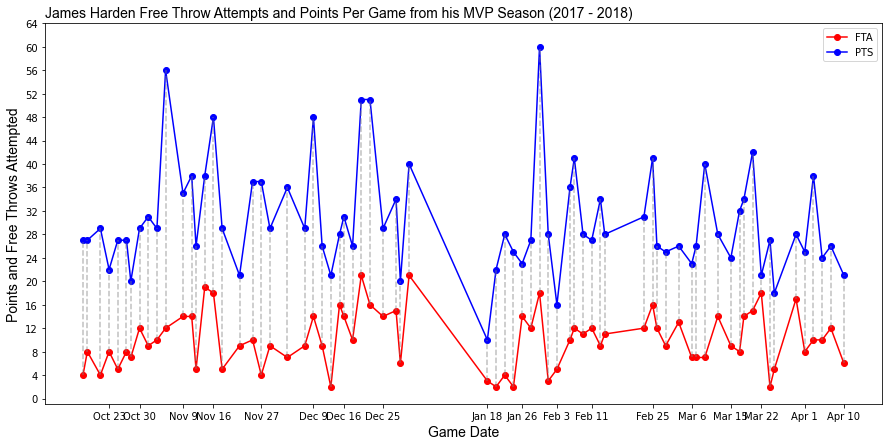

In [10]:
plt.figure(figsize = (15, 7))

font_params = {'family' : 'arial'
                , 'size' : 14}

plt.plot(HARDEN18['GAME_DATE'], HARDEN18['FTA'], color = 'red', marker = 'o')
plt.plot(HARDEN18['GAME_DATE'], HARDEN18['PTS'], color = 'blue', marker = 'o')

for t in range(0, len(HARDEN18['GAME_DATE'])):
    plt.vlines(x = HARDEN18['GAME_DATE'][t]
                , ymin = HARDEN18['FTA'][t]
                , ymax = HARDEN18['PTS'][t]
                , color = 'gray', linestyles = 'dashed', alpha = .5)

plt.xlabel('Game Date', fontdict = font_params)
plt.ylabel('Points and Free Throws Attempted', fontdict = font_params)
plt.yticks(ticks = np.arange(0, 68, step = 4))

#-- Set up x-axis
x_ticks = []
for i in np.arange(0, len(HARDEN18['GAME_DATE']), step = 4):
    x_ticks.append(HARDEN18['GAME_DATE'][i])
x_ticks = pd.Series(x_ticks)

x_labs = []
for i in range(0, len(x_ticks)):
    x_labs.append(x_ticks[i].strftime('%b %-d'))
x_labs = pd.Series(x_labs)    

plt.xticks(ticks = x_ticks, labels = x_labs)

plt.title('James Harden Free Throw Attempts and Points Per Game from his MVP Season (2017 - 2018)'
            , fontdict = font_params
            , loc = 'left')


plt.legend(labels = ['FTA', 'PTS'])

plt.show()

In [69]:
HARDEN18 = player_gl_api('James Harden', '2017')
HARDEN18['GAME_DATE'] = pd.to_datetime(HARDEN18['GAME_DATE'])

fig = go.Figure()

fig.add_trace(go.Scatter(x = HARDEN18['GAME_DATE'], y = HARDEN18['FTA'], mode = 'lines+markers', name = 'FTA'))
fig.add_trace(go.Scatter(x = HARDEN18['GAME_DATE'], y = HARDEN18['PTS'], mode = 'lines+markers', name = 'PTS'))

#fig.add_trace(go.Scatter(x = df_stocks.date, y = df_stocks['GOOG'], mode = 'lines+markers', name = 'GOOG',
#                            line = dict(color = 'firebrick', width = 2, dash = 'dashdot')))

fig.update_layout(title = 'James Harden 2017-2018 Gamelog Data'
                    , xaxis_title = 'Date'
                    , yaxis_title = 'PTS & FTA'
                    , xaxis = dict(showline = True
                                    , showgrid = True
                                    , showticklabels = True
                                    , linecolor = 'rgb(204, 204, 204)'
                                    , linewidth = 2
                                    , ticks = 'outside'
                                    , tickfont = dict(
                                        family = 'Arial'
                                        , size = 12
                                        , color = 'rgb(82, 82, 82)'
                                        )
                                    )
                    , yaxis = dict(showgrid = True
                                    , zeroline = True
                                    , showline = True
                                    , showticklabels = True
                                    )
                    , autosize = True
                    , margin = dict(autoexpand = True
                                    , l = 100
                                    , r = 200
                                    , t = 110
                                    )
                    , showlegend = True
                    , plot_bgcolor = 'white'
                    )

In [74]:
top_30_1718 = nba_1718.iloc[0:31, 1].to_list()

TS_201718 = pd.DataFrame()

for p in top_30_1718:
    
    try: 
        data = get_bb_sharpe(p, '2017')
        
        TS_201718 = pd.concat([TS_201718, data], ignore_index = True)

        time.sleep(5)
        
    except:
        pass

In [18]:
output_df = pd.DataFrame()
dame = get_bb_sharpe_years('Damian Lillard', 2013, 2021)
output_df = pd.concat([output_df, dame], ignore_index=True)
output_df.head()

,Player,Season,Games Played,Average PPG,Average FTA,Average FTPER,Volatility PPG,nbaBB Sharpe
0,Damian Lillard,2013,82,20.670732,5.195122,0.870637,7.368448,2.100254
1,Damian Lillard,2014,82,20.975610,4.853659,0.838103,7.440783,2.166701
2,Damian Lillard,2015,75,25.053333,6.186667,0.879055,8.329695,2.264989
3,Damian Lillard,2016,75,26.986667,7.266667,0.876503,8.562699,2.303012
4,Damian Lillard,2017,73,26.876712,7.369863,0.913009,7.856496,2.482894


In [32]:
top_25_2122 = nba_2122.sort_values(by = 'PTS', ascending = False).reset_index().iloc[0:26, 2]

df = get_bb_sharpe(top_25_2122[0], '2022')

,Player,Season,Games Played,Average PPG,Average FTA,Average FTPER,Volatility PPG,nbaBB Sharpe
0,Joel Embiid,2022,22,32.545455,12.0,0.842337,9.916594,2.071826


In [88]:
output_df = pd.DataFrame()

for p in top_25_2122:
    
    try: 
        data = get_bb_sharpe(p, '2022')
        
        output_df = pd.concat([output_df, data], ignore_index = True)

        time.sleep(5)
    except:
        pass

In [75]:
TS_201718 = pd.DataFrame()

for p in top_30_1718:
    
    try: 
        data = get_bb_sharpe(p, '2017')
        
        TS_201718 = pd.concat([TS_201718, data], ignore_index = True)

        time.sleep(5)
        
    except:
        pass

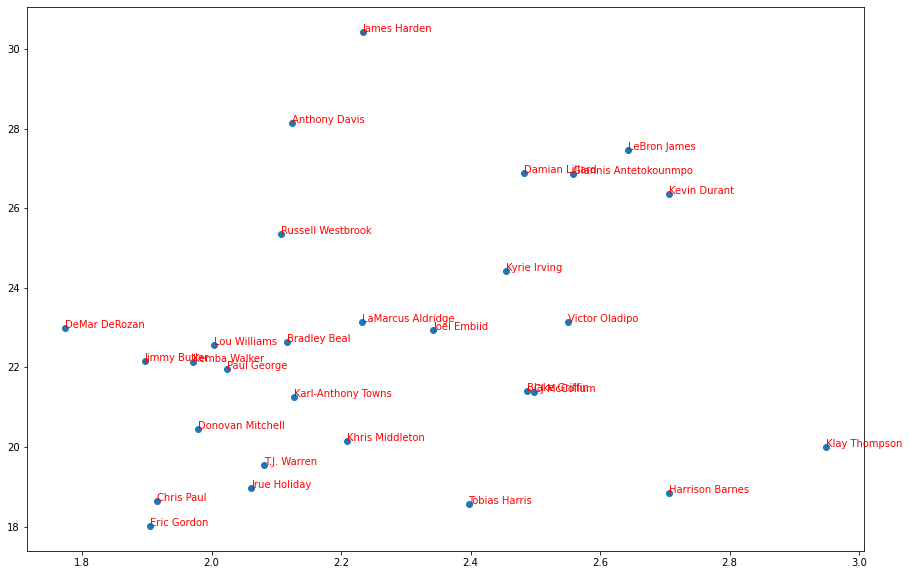

In [91]:
plt.figure(figsize = (15, 10))

plt.scatter(x = TS_201718['nbaBB Sharpe'], y = TS_201718['Average PPG'])

for i in range(0, len(TS_201718)):
    plt.text(x = TS_201718['nbaBB Sharpe'][i], y = TS_201718['Average PPG'][i], s = TS_201718['Player'][i]
                , fontdict = dict(color = 'red', size = 10)
                #, bbox = dict(facecolor= 'yellow', alpha = 0.5)
                )

plt.show()

In [93]:
#
fig = go.Figure()

fig.add_trace(go.Scatter(
    x = np.round(TS_201718['nbaBB Sharpe'], 2), y = np.round(TS_201718['Average PPG'], 2)
    , mode = 'markers'
    , marker = dict(color = TS_201718['Average FTPER'])
    , text = TS_201718['Player'], marker = dict(showscale = True)
))

fig.update_traces(marker_line_width = 2, marker_size = 10)
fig.update_layout(title = 'BB-Sharpe Ratios from the 2021-2022 NBA Season'
                    , xaxis_title = 'BB-Sharpe Ratios'
                    , yaxis_title = 'Average PPG'
                    , showlegend = True
                    , autosize = True)

fig

In [45]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x = output_df['nbaBB Sharpe'], y = output_df['Average PPG']
    , mode = 'markers', marker_color = output_df['Average FTPER']
    , text = output_df['Player'], marker = dict(showscale = True)
))

fig.update_traces(marker_line_width = 2, marker_size = 10)
fig.update_layout(title = 'BB-Sharpe Ratios from the 2021-2022 NBA Season'
                    , xaxis_title = 'BB-Sharpe Ratios'
                    , yaxis_title = 'Average PPG')

fig

In [40]:




fig.add_trace(go.Scatter( x = output_df['nbaBB Sharpe'], y = output_df['Average PPG']
    , mode = 'markers', marker_color = output_df['Average FTPER']
    , text = output_df['species'], marker = dict(showscale = True)
))

fig.update_traces(marker_line_width = 2, marker_size = 10)

,Player,Season,Games Played,Average PPG,Average FTA,Average FTPER,Volatility PPG,nbaBB Sharpe
0,Joel Embiid,2022,22,32.545455,12.000000,0.842337,9.916594,2.071826
1,LeBron James,2022,23,27.130435,5.086957,0.676346,5.727921,3.848426
2,Giannis Antetokounmpo,2022,26,31.576923,12.615385,0.639641,8.091653,2.343345
3,Kevin Durant,2022,31,30.129032,7.387097,0.932941,6.819053,3.335058
4,Trae Young,2022,29,27.551724,8.620690,0.879063,7.609369,2.487859
5,DeMar DeRozan,2022,31,25.870968,8.096774,0.895574,8.885443,2.000372
6,Kyrie Irving,2022,22,26.136364,4.363636,0.935298,8.513601,2.557405
7,Ja Morant,2022,25,27.040000,8.680000,0.711195,9.083964,2.021144
8,Jayson Tatum,2022,30,30.566667,8.333333,0.874606,8.277211,2.686090
9,Devin Booker,2022,28,28.000000,6.428571,0.861833,11.671088,1.848279


In [16]:
px.scatter(get_bb_sharpe_years('Damian Lillard', 2013, 2021), x = 'nbaBB Sharpe', y = 'Average PPG', color = 'Season')

In [ ]:
nba_mvps = ['LeBron James', 'Kevin Durant', 'Stephen Curry', 'Russell Westbrook', 'James Harden'
            , 'Giannis Antetokounmpo', 'Nikola Jokic']

bron = get_bb_sharpe('LeBron James', '2013')

for i in range(2014, 2022):
    bron = pd.concat( [bron, get_bb_sharpe('LeBron James', str(i))] )

steph = get_bb_sharpe('Stephen Curry', '2013')

for i in range(2014, 2022):
    steph = pd.concat( [steph, get_bb_sharpe('Stephen Curry', str(i))] )

giannis = get_bb_sharpe('Giannis Antetokounmpo', '2013')

for i in range(2014, 2022):
    giannis = pd.concat( [giannis, get_bb_sharpe('Giannis Antetokounmpo', str(i))] )

In [104]:
base_year = 20

for player in nba_mvps:

    

    for year in range(2014, 2022):

        base_1 = get_bb_sharpe

,Player,Season,Games Played,Average PPG,Average FTA,Volatility PPG,nbaBB Sharpe
0,Stephen Curry,2021,64,25.468750,4.656250,9.937254,2.094391
1,Giannis Antetokounmpo,2021,67,29.880597,11.432836,7.876893,2.342010
2,LeBron James,2021,56,30.267857,6.000000,7.872854,3.082473
3,Stephen Curry,2020,63,31.984127,6.269841,10.299471,2.496661
4,Giannis Antetokounmpo,2020,61,28.147541,9.524590,8.934802,2.084316
5,LeBron James,2020,45,25.022222,5.666667,6.591203,2.936574
6,Stephen Curry,2019,5,20.800000,5.200000,6.013319,2.594241
7,Giannis Antetokounmpo,2019,63,29.476190,9.984127,7.623808,2.556736
8,LeBron James,2019,67,25.343284,5.686567,6.527902,3.011185
9,LeBron James,2018,55,27.363636,7.600000,7.022985,2.814136


In [108]:
df = pd.concat([giannis, bron, steph]).sort_values('Season', ascending = True).reset_index().drop(columns = ['index'])
px.line(df, x = 'Season', y = 'nbaBB Sharpe', color = 'Player')

In [80]:
bron

,Player,Season,Games Played,Average PPG,Average FTA,Volatility PPG,nbaBB Sharpe
0,LeBron James,2013,77,27.129870,7.597403,8.328251,2.345327
0,LeBron James,2014,69,25.260870,7.652174,6.983733,2.521387
0,LeBron James,2015,76,25.263158,6.460526,5.983241,3.142550
0,LeBron James,2016,74,26.405405,7.175676,6.044696,3.181257
0,LeBron James,2017,82,27.451220,6.475610,7.934415,2.643624
0,LeBron James,2018,55,27.363636,7.600000,7.022985,2.814136
0,LeBron James,2019,67,25.343284,5.686567,6.527902,3.011185
0,LeBron James,2020,45,25.022222,5.666667,6.591203,2.936574
0,LeBron James,2021,56,30.267857,6.000000,7.872854,3.082473


In [81]:
steph

,Player,Season,Games Played,Average PPG,Average FTA,Volatility PPG,nbaBB Sharpe
0,LeBron James,2013,77,27.129870,7.597403,8.328251,2.345327
0,Stephen Curry,2014,80,23.750000,4.212500,8.104783,2.410614
0,Stephen Curry,2015,79,30.063291,5.063291,9.702331,2.576700
0,Stephen Curry,2016,79,25.303797,4.582278,7.646219,2.710035
0,Stephen Curry,2017,51,26.392157,5.921569,8.510843,2.405236
0,Stephen Curry,2018,69,27.260870,4.159420,9.663396,2.390614
0,Stephen Curry,2019,5,20.800000,5.200000,6.013319,2.594241
0,Stephen Curry,2020,63,31.984127,6.269841,10.299471,2.496661
0,Stephen Curry,2021,64,25.468750,4.656250,9.937254,2.094391


In [30]:
harden_18 = player_gl_api('Damian Lillard', '2018')

( np.mean(harden_18['PTS']) - np.mean(harden_18['FTA']) ) / np.std(harden_18['PTS'])

2.3606473442743074

In [ ]:
top_25_17_18 = ['James Harden', 'Anthony Davis', 'LeBron James', 'Giannis Antetokounmpo', 'Damian Lillard', 'Kevin Durant', 'Russell Westbrook']

In [156]:
from nba_api.stats import endpoints

data = endpoints.leagueleaders.LeagueLeaders()

data = data.get_data_frames()[0]

data.sort_values(by = 'PTS', ascending = False)



,PLAYER_ID,RANK,PLAYER,TEAM_ID,TEAM,GP,MIN,FGM,FGA,FG_PCT,...,REB,AST,STL,BLK,TOV,PF,PTS,EFF,AST_TOV,STL_TOV
0,1628369,1,Jayson Tatum,1610612738,BOS,52,1942,516,1117,0.462,...,453,236,54,39,148,115,1590,1564,1.59,0.36
1,1629029,2,Luka Doncic,1610612742,DAL,47,1714,529,1050,0.504,...,416,387,71,24,171,130,1569,1633,2.26,0.41
2,1628983,3,Shai Gilgeous-Alexander,1610612760,OKC,50,1770,512,1012,0.506,...,233,282,84,54,142,135,1538,1504,1.99,0.59
3,1630162,4,Anthony Edwards,1610612750,MIN,58,2099,517,1115,0.464,...,348,265,96,35,193,145,1435,1314,1.37,0.50
4,203507,5,Giannis Antetokounmpo,1610612749,MIL,43,1433,492,910,0.541,...,534,230,33,34,174,149,1385,1423,1.32,0.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,1630792,495,Malcolm Hill,1610612741,CHI,4,2,0,0,0.000,...,1,0,0,0,0,0,0,1,0.00,0.00
499,1630250,495,Marko Simonovic,1610612741,CHI,2,3,0,1,0.000,...,0,0,0,0,0,0,0,-1,0.00,0.00
500,1630701,495,Michael Foster Jr.,1610612755,PHI,1,1,0,0,0.000,...,0,0,0,0,0,0,0,0,0.00,0.00
501,1628425,495,Sterling Brown,1610612747,LAL,4,24,0,4,0.000,...,8,2,3,0,0,4,0,9,0.00,0.00


In [160]:
data.reset_index()

,index,PLAYER_ID,RANK,PLAYER,TEAM_ID,TEAM,GP,MIN,FGM,FGA,...,AST,STL,BLK,TOV,PF,PTS,EFF,AST_TOV,STL_TOV,PPG
0,1,1629029,2,Luka Doncic,1610612742,DAL,47,1714,529,1050,...,387,71,24,171,130,1569,1633,2.26,0.41,33.382979
1,6,203954,7,Joel Embiid,1610612755,PHI,41,1427,453,853,...,166,46,65,150,133,1365,1436,1.11,0.31,33.292683
2,4,203507,5,Giannis Antetokounmpo,1610612749,MIL,43,1433,492,910,...,230,33,34,174,149,1385,1423,1.32,0.19,32.209302
3,7,203081,8,Damian Lillard,1610612757,POR,43,1556,398,860,...,314,36,13,132,84,1328,1245,2.38,0.27,30.883721
4,2,1628983,3,Shai Gilgeous-Alexander,1610612760,OKC,50,1770,512,1012,...,282,84,54,142,135,1538,1504,1.99,0.59,30.760000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,494,1631214,495,Alondes Williams,1610612751,BKN,1,5,0,0,...,0,0,0,2,1,0,-1,0.00,0.00,0.000000
499,497,1630577,495,Julian Champagnie,1610612755,PHI,2,7,0,2,...,0,1,0,0,0,0,-1,0.00,0.00,0.000000
500,496,1629126,495,Deonte Burton,1610612758,SAC,2,7,0,2,...,0,0,0,0,0,0,-2,0.00,0.00,0.000000
501,495,1631205,495,Buddy Boeheim,1610612765,DET,1,1,0,0,...,0,0,0,0,0,0,0,0.00,0.00,0.000000


In [162]:
nba_2k23_player_ids = data.iloc[1:31,1].to_list()
nba_2k23_player_names = data.iloc[1:31,3].to_list()



'Joel Embiid'

In [161]:
from nba_api.stats import endpoints

data = endpoints.leagueleaders.LeagueLeaders()

data = data.get_data_frames()[0]

data.sort_values(by = 'PTS', ascending = False)

data['PPG'] = data['PTS'] / data['GP']
data =  data.sort_values(by = 'PPG', ascending = False)
data = data.reset_index()
data.iloc[1:31,:]

nba_2k23_player_ids = data.iloc[1:31,1].to_list()
nba_2k23_player_names = data.iloc[1:31,3].to_list()

,index,PLAYER_ID,RANK,PLAYER,TEAM_ID,TEAM,GP,MIN,FGM,FGA,...,AST,STL,BLK,TOV,PF,PTS,EFF,AST_TOV,STL_TOV,PPG
1,6,203954,7,Joel Embiid,1610612755,PHI,41,1427,453,853,...,166,46,65,150,133,1365,1436,1.11,0.31,33.292683
2,4,203507,5,Giannis Antetokounmpo,1610612749,MIL,43,1433,492,910,...,230,33,34,174,149,1385,1423,1.32,0.19,32.209302
3,7,203081,8,Damian Lillard,1610612757,POR,43,1556,398,860,...,314,36,13,132,84,1328,1245,2.38,0.27,30.883721
4,2,1628983,3,Shai Gilgeous-Alexander,1610612760,OKC,50,1770,512,1012,...,282,84,54,142,135,1538,1504,1.99,0.59,30.760000
5,0,1628369,1,Jayson Tatum,1610612738,BOS,52,1942,516,1117,...,236,54,39,148,115,1590,1564,1.59,0.36,30.576923
6,8,2544,8,LeBron James,1610612747,LAL,44,1603,510,1004,...,309,43,24,138,72,1328,1380,2.24,0.31,30.181818
7,19,201142,20,Kevin Durant,1610612751,BKN,39,1403,410,734,...,207,32,57,136,92,1158,1237,1.52,0.23,29.692308
8,26,201939,27,Stephen Curry,1610612744,GSW,38,1313,372,751,...,244,37,15,122,82,1119,1139,2.00,0.30,29.447368
9,13,1629630,14,Ja Morant,1610612763,MEM,45,1471,436,932,...,373,45,13,159,81,1235,1179,2.35,0.28,27.444444
10,27,202681,28,Kyrie Irving,1610612742,DAL,41,1515,407,836,...,216,42,34,96,112,1108,1062,2.25,0.44,27.024390
